## Generate the mesh

In [ ]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [ ]:
from convert_mesh import convert_mesh
from pathlib import Path

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)
nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)


meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
def run(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2
    import time

    start = time.perf_counter()
    run_festim_2(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


In [7]:
import ipyparallel as ipp
import numpy as np

# check if we are in github actions
import os
# if "CI" in os.environ:
#     num_procs = [1, 2, 4]
# else:
#num_procs = [1, 2, 4, 8, 16]
num_procs = [3, 8]
runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.73s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 276364, 'identifier': 'ipcontroller-1730145225-p6uu-275275'}
Stopping engine(s): 1730145226
Output for ipengine-1730145225-p6uu-1730145226-275275:
2024-10-28 15:53:47.350 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-10-28 15:53:47.351 [IPEngine] WARNING | Not using CurveZMQ security
2024-10-28 15:53:47.433 [IPEngine] Registering with controller at tcp://127.0.0.1:56081
2024-10-28 15:53:47.437 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:34131', 'tcp://127.0.0.1:48545', 'tcp://127.0.0.1:33329']
2024-10-28 15:53:47.438 [IPEngine] Connecting shell to tcp://127.0.0.1:34131
2024-10-28 15:53:47.438 [IPEngine] Connecting shell to tcp://127.0.0.1:48545
2024-10-28 15:53:47.438 [IPEngine] Connecting shell to tcp://127.0.0.1:33329
2024-10-28 15:53:47.438 [IPEn

CompositeError: one or more exceptions raised in: run
[0:apply]RuntimeError: Linear solver did not converge, got reason: -11
[1:apply]RuntimeError: Linear solver did not converge, got reason: -11
[2:apply]RuntimeError: Linear solver did not converge, got reason: -11
[3:apply]RuntimeError: Linear solver did not converge, got reason: -11
.... 4 more exceptions ...

109293


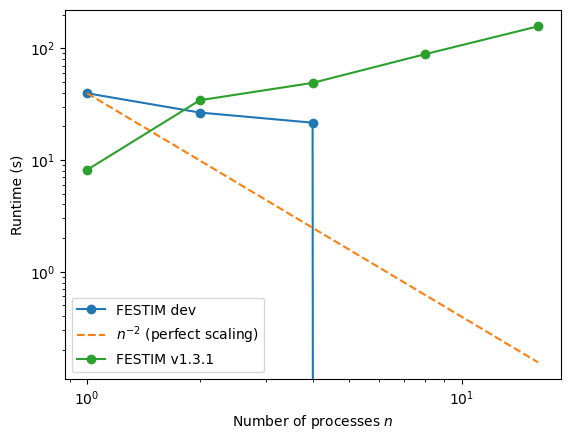

In [9]:
import matplotlib.pyplot as plt
from festim import __version__

plt.plot(num_procs, runtimes, marker="o", label=f"FESTIM dev")

n = np.linspace(1, 16, 100)
plt.plot(n, runtimes[0] * n**-2, linestyle="--", label="$n^{-2}$ (perfect scaling)")

plt.xlabel("Number of processes $n$")
plt.ylabel("Runtime (s)")

plt.xscale("log")
plt.yscale("log")

# check that runtimes_festim_1.csv exists and plot the results
try:
    import pandas as pd
    data = pd.read_csv("runtimes_festim_1.csv")
    plt.plot(data["num_procs"], data["runtimes"], marker="o", label="FESTIM v1.3.1")
except FileNotFoundError:
    print("File runtimes_festim_1.csv not found")

plt.legend()
plt.show()

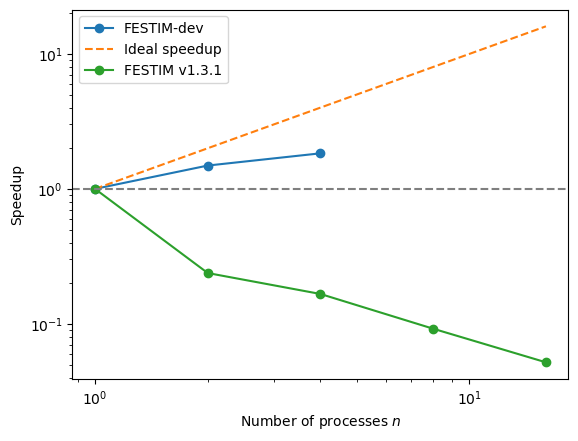

In [10]:
speedup = runtimes[0] / runtimes

plt.plot(num_procs, speedup, marker="o", label=f"FESTIM-dev")
# ideal speedup
plt.plot(n, n, linestyle="--", label="Ideal speedup")


try:
    import pandas as pd
    data = pd.read_csv("runtimes_festim_1.csv")
    speedup = data["runtimes"][0] / data["runtimes"]
    plt.plot(data["num_procs"], speedup, marker="o", label="FESTIM v1.3.1")
except FileNotFoundError:
    print("File runtimes_festim_1.csv not found")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of processes $n$")
plt.ylabel("Speedup")

# horizontal line at 1
plt.axhline(1, color="tab:grey", linestyle="--")

plt.legend()
plt.show()